# Energy Consumption Project

This notebook shows how to predict energy consumption by a household using [Residential Energy Consumption Survey Dataset](https://www.eia.gov/consumption/residential/data/2015/) conducted by U.S. Energy Information Adminstration.

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_theme()
RANDOM_STATE = 0

In [119]:
data = pd.read_csv('data/recs2015_public_v4.csv')
print(data.shape)
data.head()

(5686, 759)


,DOEID,REGIONC,DIVISION,METROMICRO,UATYP10,TYPEHUQ,ZTYPEHUQ,CELLAR,ZCELLAR,BASEFIN,...,ZELAMOUNT,NGXBTU,PERIODNG,ZNGAMOUNT,FOXBTU,PERIODFO,ZFOAMOUNT,LPXBTU,PERIODLP,ZLPAMOUNT
0,10001,4,10,METRO,U,2,0,0,0,-2,...,0,103.32,1,0,137.45,-2,-2,91.33,-2,-2
1,10002,3,7,NONE,R,2,0,0,0,-2,...,1,NaN,-2,-2,137.45,-2,-2,91.33,-2,-2
2,10003,3,6,METRO,U,2,0,1,0,1,...,0,100.14,1,0,137.45,-2,-2,91.33,-2,-2
3,10004,2,4,MICRO,C,2,0,1,0,1,...,0,NaN,-2,-2,137.45,-2,-2,91.33,2,0
4,10005,1,2,METRO,U,2,0,1,0,0,...,0,102.83,1,0,137.45,-2,-2,91.33,-2,-2


As we see, there's 759 different features, such as DIVISION - region of US, TYPEHUQ - Type of Housing Unit, TOTROOMS - total number of rooms etc.

# EDA

Text(0, 0.5, 'MEAN TOTALBTU (Total Energy Consumption in BTU)')

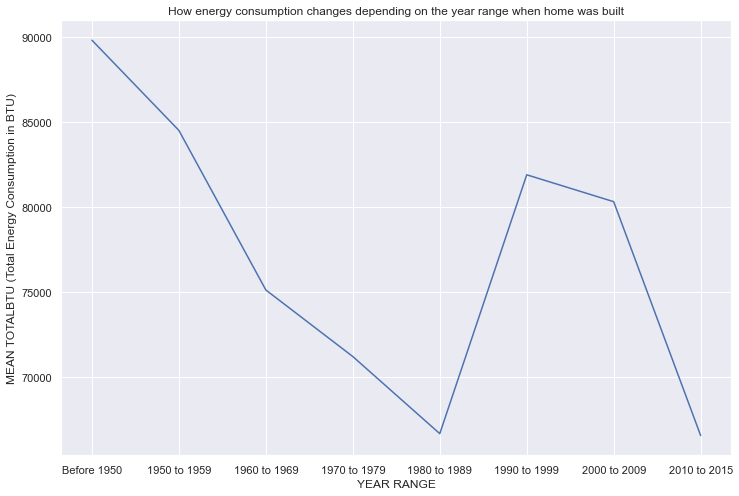

In [79]:
year_ranges = {
    '0': 'Before 1950',
    '1': '1950 to 1959',
    '2': '1960 to 1969',
    '3': '1970 to 1979',
    '4': '1980 to 1989',
    '5': '1990 to 1999',
    '6': '2000 to 2009',
    '7': '2010 to 2015'
}

gouped_by_year = data.groupby('YEARMADERANGE')['TOTALBTU'].mean()
gouped_by_year .plot(figsize=(12,8))
plt.title('How energy consumption changes depending on the year range when home was built')
labels = [year_ranges[str(i-1)] for i in gouped_by_year.index]
plt.xticks(ticks=[i+1 for i in range(len(labels))],labels=labels)
plt.xlabel('YEAR RANGE')
plt.ylabel('MEAN TOTALBTU (Total Energy Consumption in BTU)')

Text(0, 0.5, 'Count')

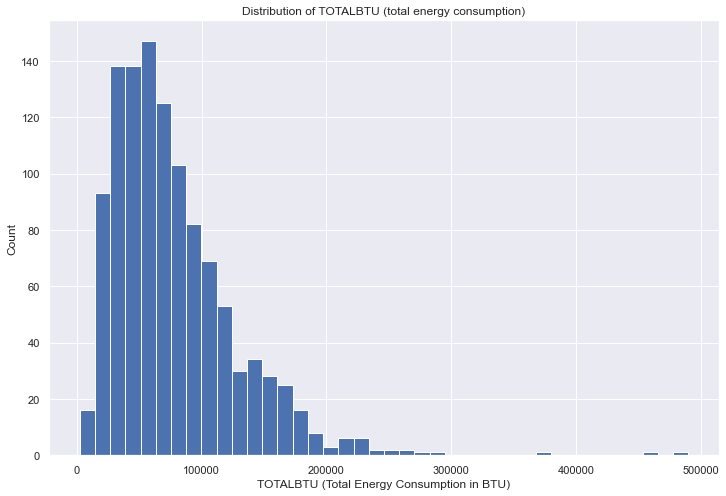

In [80]:
data[data.YEARMADERANGE.isin([7,8])]['TOTALBTU'].hist(bins=40, figsize=(12,8))
plt.title('Distribution of TOTALBTU (total energy consumption)')
plt.xlabel('TOTALBTU (Total Energy Consumption in BTU)')
plt.ylabel('Count')

Text(0, 0.5, 'MEAN TOTALBTU (Total Energy Consumption in BTU)')

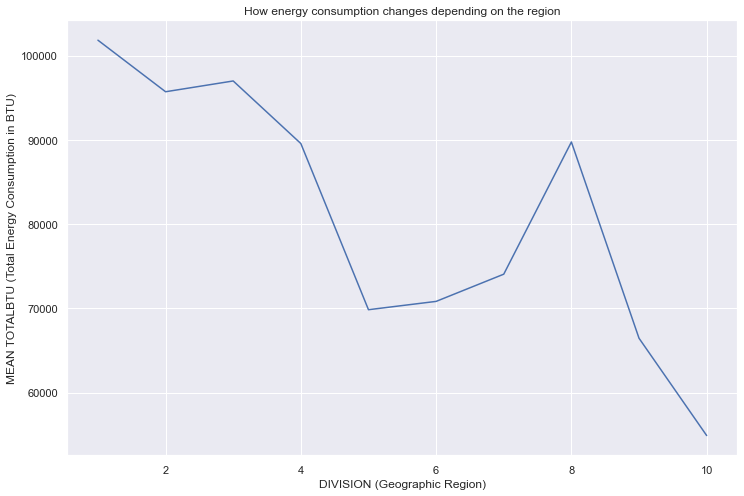

In [81]:
data.groupby('DIVISION')['TOTALBTU'].mean().plot(figsize=(12,8))
plt.title('How energy consumption changes depending on the region')
plt.xlabel('DIVISION (Geographic Region)')
plt.ylabel('MEAN TOTALBTU (Total Energy Consumption in BTU)')

# Feature Engineering

Drop features with standard deviation less than 0.05

In [120]:
threshold = 0.05
data = data.drop(data.std()[data.std() < threshold].index.values, axis=1)

Add population of the region, unemployment rate and GDP. These three features may be important in energy consumption estimation.

In [83]:
Unemployment_Rate = {
    'New England':5.0,
    'Middle Atlantic':5.3,
    'East North Central':5.2,
    'West North Central':4.0,
    'South Atlantic':5.5,
    'East South Central':5.9,
    'West South Central':4.7,
    'Mountain North':5.1,
    'Mountain South':5.1,
    'Pacific':6.0
}

In [84]:
GDP = {
    'New England':1.0,
    'Middle Atlantic':3.3,
    'East North Central':2.5,
    'West North Central':1.2,
    'South Atlantic':3.9,
    'East South Central':3.9,
    'West South Central':3.9,
    'Mountain North':0.6,
    'Mountain South':2.1,
    'Pacific':3.5
}

In [85]:
regions = {
    'New England':['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont'],
    'Middle Atlantic':['New Jersey', 'New York', 'Pennsylvania'],
    'East North Central':['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
    'West North Central':['Iowa, Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South Atlantic':['Delaware','Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'Washington, D.C.','West Virginia'],
    'East South Central': ['Alabama', 'Kentucky', 'Mississippi', 'Tennessee'],
    'West South Central':['Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'Mountain North':['Idaho', 'Montana', 'Wyoming'],
    'Mountain South':['Arizona','New Mexico', 'Utah', 'Nevada', 'Colorado'],
    'Pacific':['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}
states = {}

for reg in regions.keys():
    for state in regions[reg]:
        states[state] = reg

In [121]:
population = pd.read_csv('data/nst-est2019-alldata.csv')
population['REGIONC'] = population['NAME'].apply(lambda n: states[n] if n in states.keys() else np.nan)
population = population.dropna()
pops = dict(population.groupby('REGIONC')['POPESTIMATE2015'].mean())
data["POPULATION"] = data['DIVISION'].apply(lambda i:list(pops.values())[int(i)-1])
data["GDP"] = data['DIVISION'].apply(lambda i:list(GDP.values())[int(i)-1])
data["Unemployment_Rate"] = data['DIVISION'].apply(lambda i:list(Unemployment_Rate.values())[int(i)-1])

# Drop columns that we don't know

In [122]:
cols_to_drop = ['CUFEETNG', 'MONEYPY']

In [123]:
cols_to_drop.extend([col for col in list(data.columns) 
                     if (col.find('BTU')!=-1 and col!='TOTALBTU') 
                     or col.find('KWH')!=-1 
                     or col.find('CUFEET')!=-1
                     or (col.find('TOTAL')!=-1 and col!='TOTALBTU')
                     or col.find('Z')==0])

In [124]:
data = data.drop(cols_to_drop, axis=1)

# Add a few new features

In [125]:
data['AVGROOMSQFT'] = data["TOTHSQFT"]/data['TOTROOMS']
data['PARTOFBEDROOMS'] = data['BEDROOMS']/data['TOTROOMS']
data['BATHPERROOM'] = data['NCOMBATH']/data['TOTROOMS']
data['WINPERROOM'] = data['WINDOWS']/data['TOTROOMS']
data['NUMOFTOOLS'] = data['OVEN']+data['MICRO']+data['TOAST']+data['COFFEE']+data['CROCKPOT']+data['FOODPROC']+data['BLENDER']+data['DISHWASH']

# Keep only the data about houses built in the ranges 7 and 8

In [126]:
data = data[data.YEARMADERANGE.isin([7,8])]

# Create train/test and val splits

In [127]:
X_full = data.drop(['TOTALBTU'], axis=1)
y_full = data[['TOTALBTU']]
X, X_val, y, y_val = train_test_split(X_full, y_full, test_size=0.1, random_state=RANDOM_STATE)

# Impute NANs

In [128]:
features = list(X.columns)
X = X.replace(-2, np.nan)
print(X.shape)
f_withna = dict(X.isna().sum())
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X = imp.fit_transform(X)

withna = list(f_withna.keys())
f_tokeep = {k: v for k, v in f_withna.items() if v==0}
print(f'Number of columns with NAN: {len(list(f_tokeep.keys()))}')

(1017, 442)
Number of columns with NAN: 298


In [94]:
X

array([[12679, 1, 2, ..., 0.25, 10.25, 3],
       [13600, 3, 5, ..., 0.2, 2.0, 4],
       [12063, 3, 5, ..., 0.4, 8.2, 5],
       ...,
       [14100, 3, 5, ..., 0.3, 4.1, 5],
       [12802, 3, 5, ..., 0.3, 4.2, 4],
       [13324, 4, 10, ..., 0.2222222222222222, 4.666666666666667, 6]],
      dtype=object)

In [129]:
X = pd.DataFrame(X, columns=features)

In [130]:
cat_features = ['METROMICRO', 'UATYP10', 'CLIMATE_REGION_PUB', 'IECC_CLIMATE_PUB']
num_features = [f for f in features if f not in cat_features]

In [131]:
X[num_features] = X[num_features].astype(np.float32)

In [99]:
X.dtypes

DOEID             float32
REGIONC           float32
DIVISION          float32
METROMICRO         object
UATYP10            object
                   ...   
AVGROOMSQFT       float32
PARTOFBEDROOMS    float32
BATHPERROOM       float32
WINPERROOM        float32
NUMOFTOOLS        float32
Length: 442, dtype: object

In [132]:
X = pd.get_dummies(X)

# Baseline - Linear Regression

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(k=170, score_func=f_regression)
select.fit(X_train, y_train)
print(X_train.shape)
X_train_ = select.transform(X_train)
X_test_ = select.transform(X_test)
print(X_train_.shape)

lr = LinearRegression()
lr.fit(X_train_,y_train)
y_pred_lr = lr.predict(X_test_)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("RMSE: %f" % (rmse))

(813, 460)
(813, 170)
RMSE: 11374.720159


# Permutation Importance 

In [135]:
# pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(lr, random_state=1).fit(X_test_, y_test)
eli5.show_weights(perm, feature_names = select.get_feature_names_out())

Weight,Feature
10.3758 ± 1.9443,TOTHSQFT
9.1639 ± 0.8553,TOTCSQFT
7.0557 ± 0.4444,DOLLARNG
5.9185 ± 0.4728,DOLNGSPH
4.6588 ± 0.2977,TOTUCSQFT
3.5156 ± 0.2676,TOTUSQFT
1.2756 ± 0.1996,DOLNGWTH
0.5104 ± 0.0399,DOLNGNEC
0.4700 ± 0.0696,GALLONLP
0.4559 ± 0.0381,DOLLAREL


In [136]:
df_fi = pd.DataFrame(dict(feature_names=select.get_feature_names_out(),
                          feat_imp=perm.feature_importances_, 
                          std=perm.feature_importances_std_,
                          ))
df_fi = df_fi.round(4)
df_fi.sort_values('feat_imp', ascending=False)

,feature_names,feat_imp,std
106,TOTHSQFT,10.3758,0.9721
105,TOTCSQFT,9.1639,0.4277
143,DOLLARNG,7.0557,0.2222
144,DOLNGSPH,5.9185,0.2364
108,TOTUCSQFT,4.6588,0.1488
...,...,...,...
42,AGEDW,-0.0006,0.0004
32,OVENUSE,-0.0009,0.0004
17,MONPOOL,-0.0010,0.0003
12,HIGHCEIL,-0.0017,0.0010


# Leave only the important features

In [137]:
imp_fs = list(df_fi[df_fi['feat_imp']>0]['feature_names'].values)
print(f'Using {len(imp_fs)} features')

Using 123 features


In [151]:

X_train_ = X_train[select.get_feature_names_out()][imp_fs]
X_test_ = X_test[select.get_feature_names_out()][imp_fs]
lr = LinearRegression()
lr.fit(X_train_,y_train)
y_pred_lr = lr.predict(X_test_)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("RMSE: %f" % (rmse))

RMSE: 10537.574399


# XGBoost

In [152]:
from xgboost import XGBRegressor

regr = XGBRegressor(booster='gblinear', n_estimators=870, seed=0, learning_rate=0.1, gamma=1., random_state=RANDOM_STATE).fit(X_train_, y_train)
y_pred_ridge = regr.predict(X_test_)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("RMSE: %f" % (rmse))

[13:56:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 10230.905459


# Hyperparameter Tuning

In [153]:
hyperparameter_grid = {
    'n_estimators': [700, 800, 900],
    'max_depth': [2, 5, 10],
    'learning_rate': [0.1, 0.3, 0.5],
    'min_child_weight': [1, 2, 3, 4],
    'random_state':[RANDOM_STATE]
    }

In [154]:
grid_cv = GridSearchCV(estimator=regr,
            param_grid=hyperparameter_grid,
            cv=3, 
            scoring = 'neg_mean_squared_error',n_jobs = 4,
            verbose = 2, 
            return_train_score = True)

grid_cv.fit(X_train_,y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[13:58:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "gamma", "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=0.5, booster='gblinear',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=1.0, gpu_id=-1, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_bin=None,
                                    max_ca...
                                    monotone_constraints=None, n_estimators=870,
                                    n_jobs=0, num_parallel_tree=None,
                                    predictor=None, random_state=0, reg_alpha=0,
                        

In [156]:
regr = XGBRegressor(booster='gblinear', **grid_cv.best_params_).fit(X_train_, y_train)
y_pred_xgb = regr.predict(X_test_)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("RMSE: %f" % (rmse))

[13:59:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_depth", "min_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


RMSE: 10232.773881


In [160]:
X_train.shape, X_val.shape

((813, 460), (114, 442))

# Inference on Val set

In [172]:
X_val_ = X_val.replace(-2, np.nan)
X_val_ = imp.transform(X_val_)
X_val_ = pd.DataFrame(X_val_, columns=features)
X_val_[num_features] = X_val_[num_features].astype(np.float32)
X_val_ = pd.get_dummies(X_val_)
X_val_ = X_val_[select.get_feature_names_out()][imp_fs]
y_pred_xgb = regr.predict(X_val_)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print("RMSE: %f" % (rmse))

RMSE: 11426.843288


# References

- [Residential Energy Consumption Survey Dataset](https://www.eia.gov/consumption/residential/data/2015/)
- [Factors Influencing Energy Consumption in the Context of Sustainable Development](https://www.mdpi.com/2071-1050/11/15/4147/pdf)
- [Factors affecting electricity consumption of residential consumers in Cambodia](https://iopscience.iop.org/article/10.1088/1755-1315/746/1/012034/pdf)